In [22]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)


In [23]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [32]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world,
        absolute_title_subjectivity = abs_title_subjectivity,
        title_length = n_tokens_title,
        absolute_title_sentiment_polarity = abs_title_sentiment_polarity,
        meta_tags = num_keywords
    )
head(named_data,1)

url,timedelta,title_length,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,absolute_title_subjectivity,absolute_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593


In [33]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    #select(Day_Of_Week,Genre, n_tokens_title, num_keywords, title_subjectivity, abs_title_subjectivity, title_sentiment_polarity,abs_title_sentiment_polarity, shares)
    select(title_length, meta_tags, title_subjectivity,title_sentiment_polarity,absolute_title_subjectivity,absolute_title_sentiment_polarity, shares)



In [34]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)


title_length,meta_tags,title_subjectivity,title_sentiment_polarity,absolute_title_subjectivity,absolute_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,5,0.5000000,-0.1875000,0.00000000,0.1875000,593
9,4,0.0000000,0.0000000,0.50000000,0.0000000,711
9,6,0.0000000,0.0000000,0.50000000,0.0000000,1500
9,7,0.0000000,0.0000000,0.50000000,0.0000000,1200
13,7,0.4545455,0.1363636,0.04545455,0.1363636,505
10,9,0.6428571,0.2142857,0.14285714,0.2142857,855


In [35]:
#options(repr.plot.width = 10, repr.plot.height = 10)

#genre_data <- publishing_train %>%
#    group_by(Genre) %>%
#    summarise(n=n(), shares = mean(shares))

#share_genre_plot <- genre_data %>%
#    ggplot(aes(x = Genre, y = shares)) + 
#    geom_bar(stat = 'identity') +
#    xlab("Genre of Article") +
#    ylab("Number of Shares") +
#    theme(text = element_text(size = 20))

#share_genre_plot


#    ggplot(aes(value, fill = Genre)) +
#        geom_density(alpha = 0.4, colour = 'white') +
#        facet_wrap(~ Day_Of_Week, scales = 'free') +
#        theme_minimal() +
#        theme(text = element_text(size = 20))

In [36]:
#day_data <- publishing_train %>%
#    group_by(Day_Of_Week) %>%
#    summarise(n=n(), shares = mean(shares))


#options(repr.plot.width = 10, repr.plot.height = 10)
#share_day_plot <- day_data %>%
#    ggplot(aes(x = Day_Of_Week, y = shares)) + 
#    geom_bar(stat = 'identity') +
#    xlab("Genre of Article") +
#    ylab("Number of Shares") +
#    theme(text = element_text(size = 20))

#share_day_plot

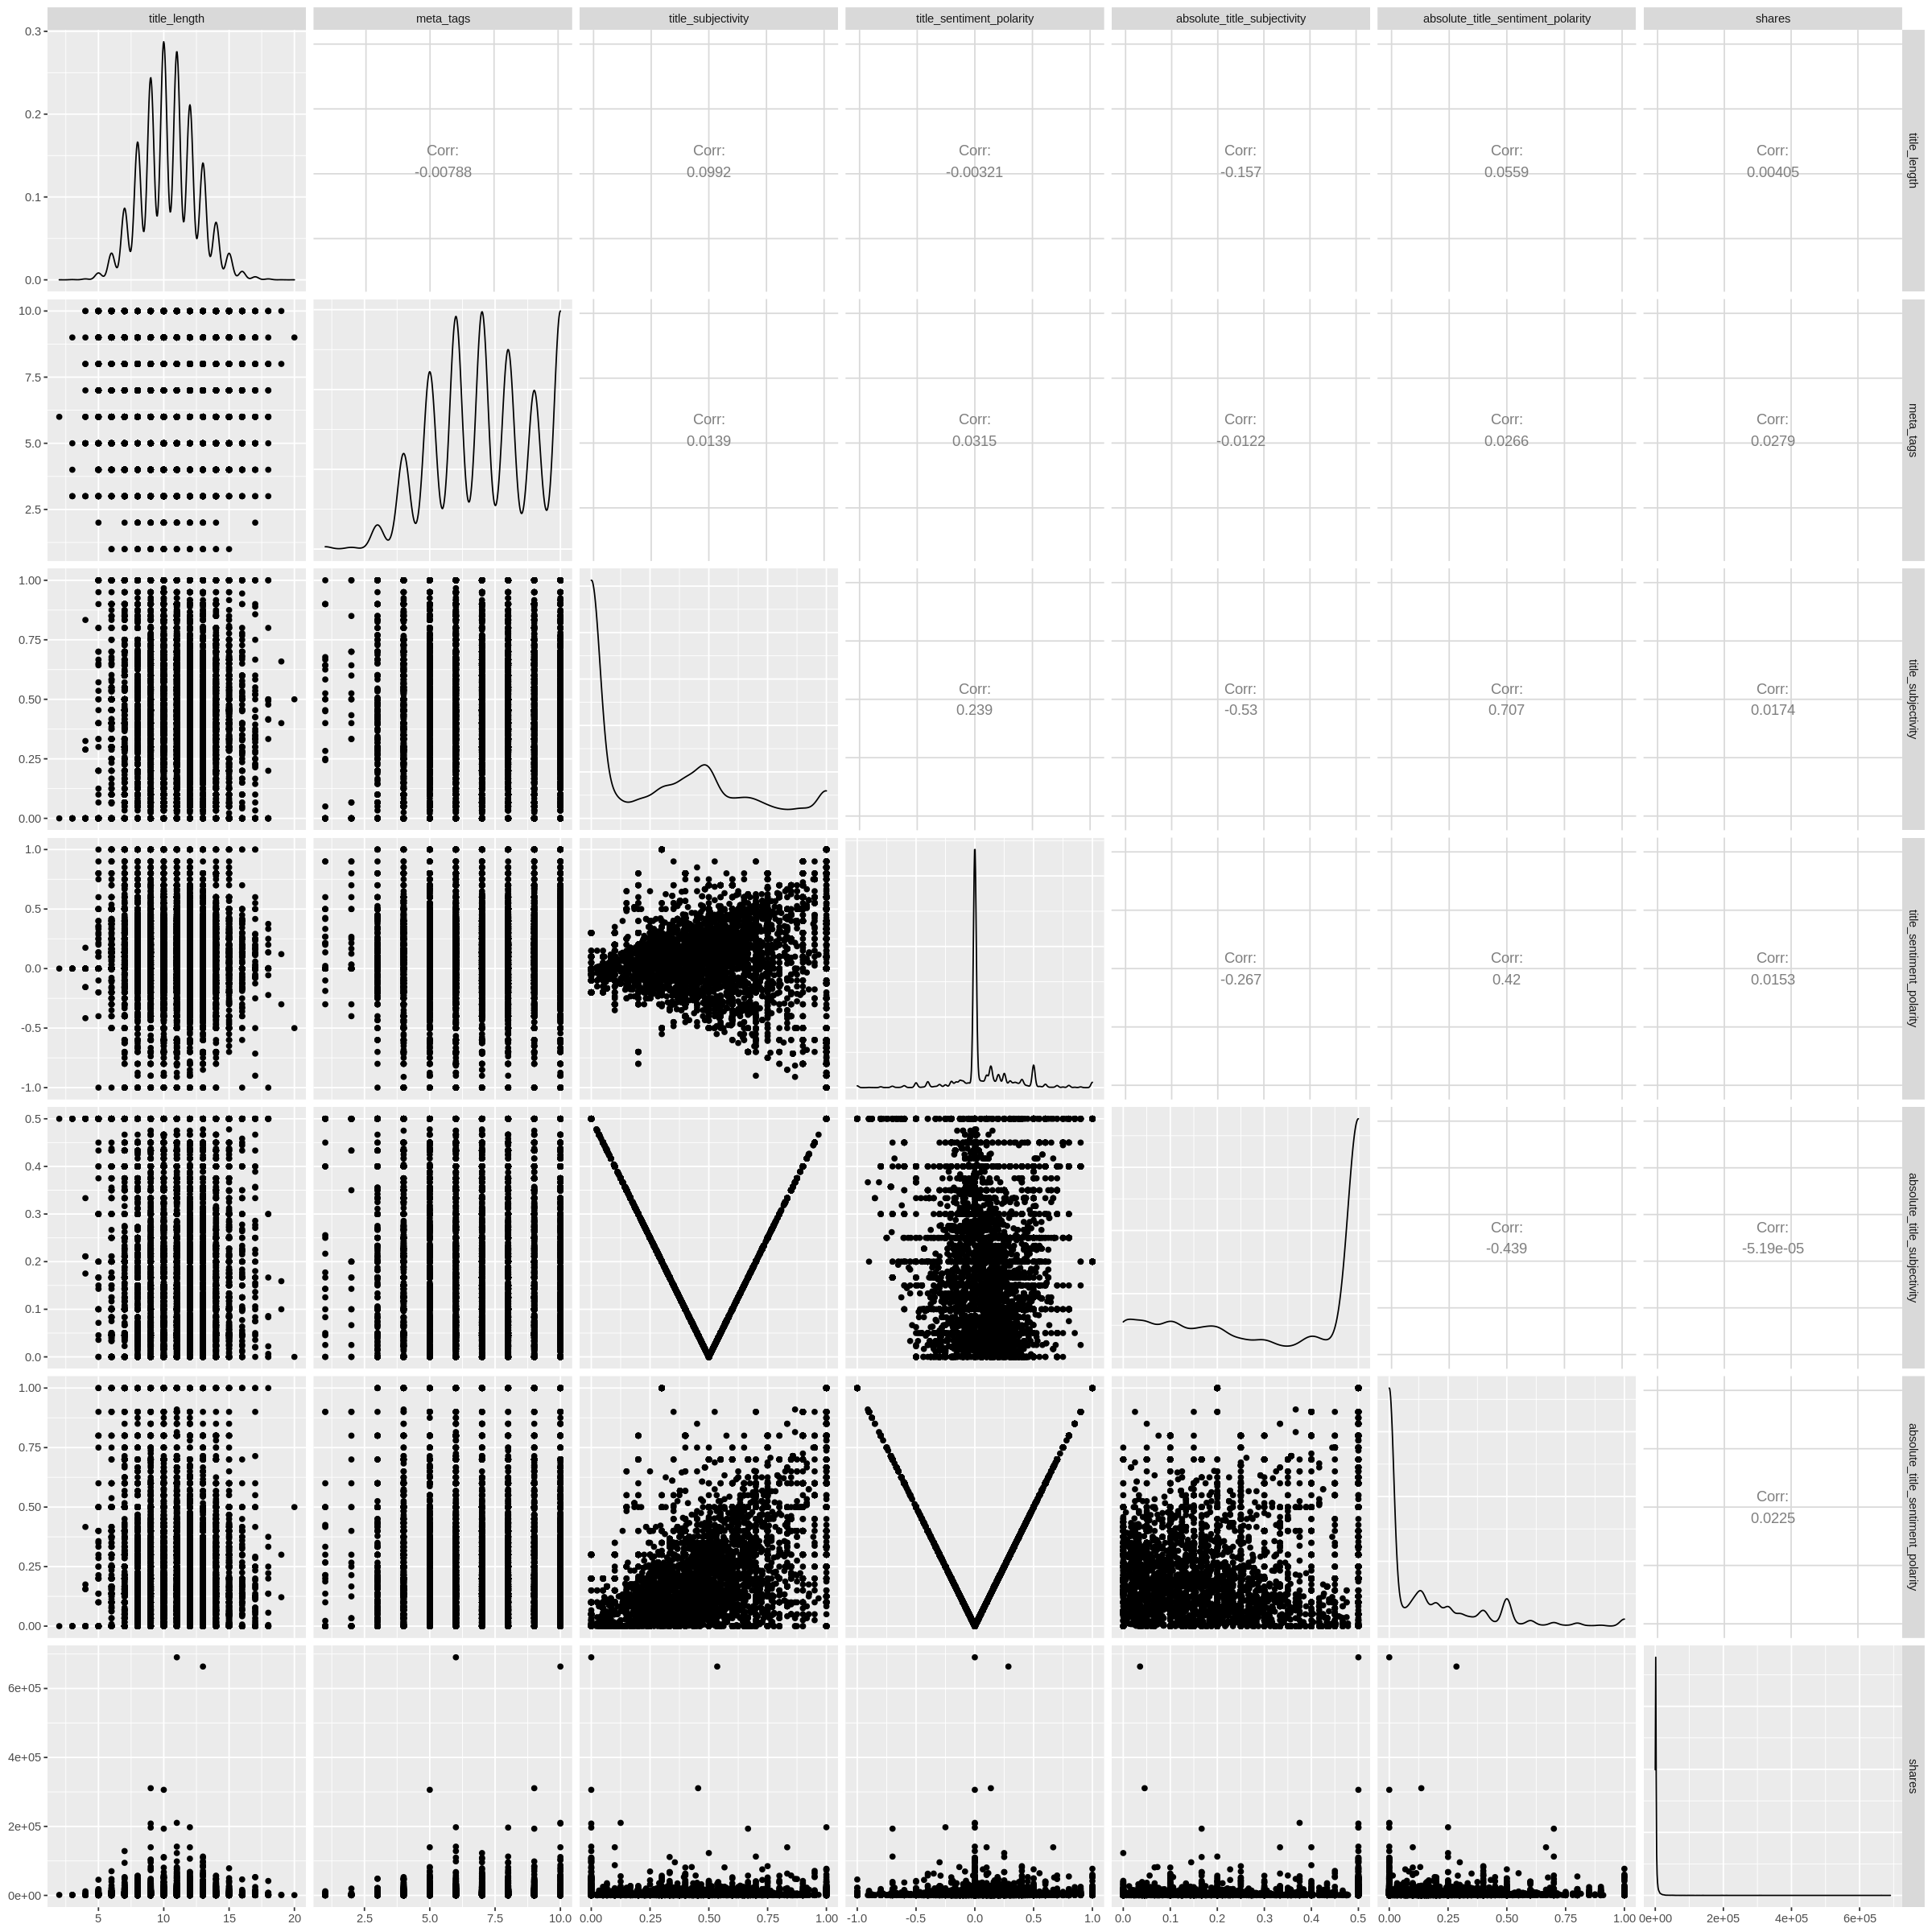

In [37]:
options(repr.plot.width = 20, repr.plot.height = 20)

#pairs <- select(publishing_train, -Genre, -Day_Of_Week) %>%
#    ggpairs()
#pairs
pairs <- publishing_train %>%
    ggpairs()
pairs

In [40]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 



#share_recipe <- recipe(shares ~ n_tokens_title+ num_keywords+abs_title_sentiment_polarity+Genre+Day_Of_Week, data = publishing_train) %>%
#       step_scale(-shares, -Genre, -Day_Of_Week) %>%
#       step_center(-shares, -Genre, -Day_Of_Week)
share_recipe <- recipe(shares ~ title_length+absolute_title_sentiment_polarity+meta_tags, data = publishing_train) %>%
       step_scale(-shares) %>%
       step_center(-shares)

In [41]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)

share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 25:400) %>%
    filter(neighbors %% 25 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,9.032995e+03,5,1.202070e+03,Model01
25,rsq,standard,5.375623e-05,5,1.965729e-05,Model01
50,rmse,standard,9.053298e+03,5,1.124630e+03,Model02
50,rsq,standard,1.301706e-04,5,8.570548e-05,Model02
75,rmse,standard,8.935227e+03,5,1.156209e+03,Model03
75,rsq,standard,6.899397e-05,5,4.517061e-05,Model03
100,rmse,standard,8.883032e+03,5,1.171225e+03,Model04
100,rsq,standard,1.870491e-04,5,8.840503e-05,Model04
125,rmse,standard,8.868779e+03,5,1.173202e+03,Model05


In [42]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
375,rmse,standard,8806.279,5,1188.115,Model15


In [43]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)


share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.046507e+04
rsq,standard,2.907935e-04
mae,standard,2.653439e+03


[1] 10458.32

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



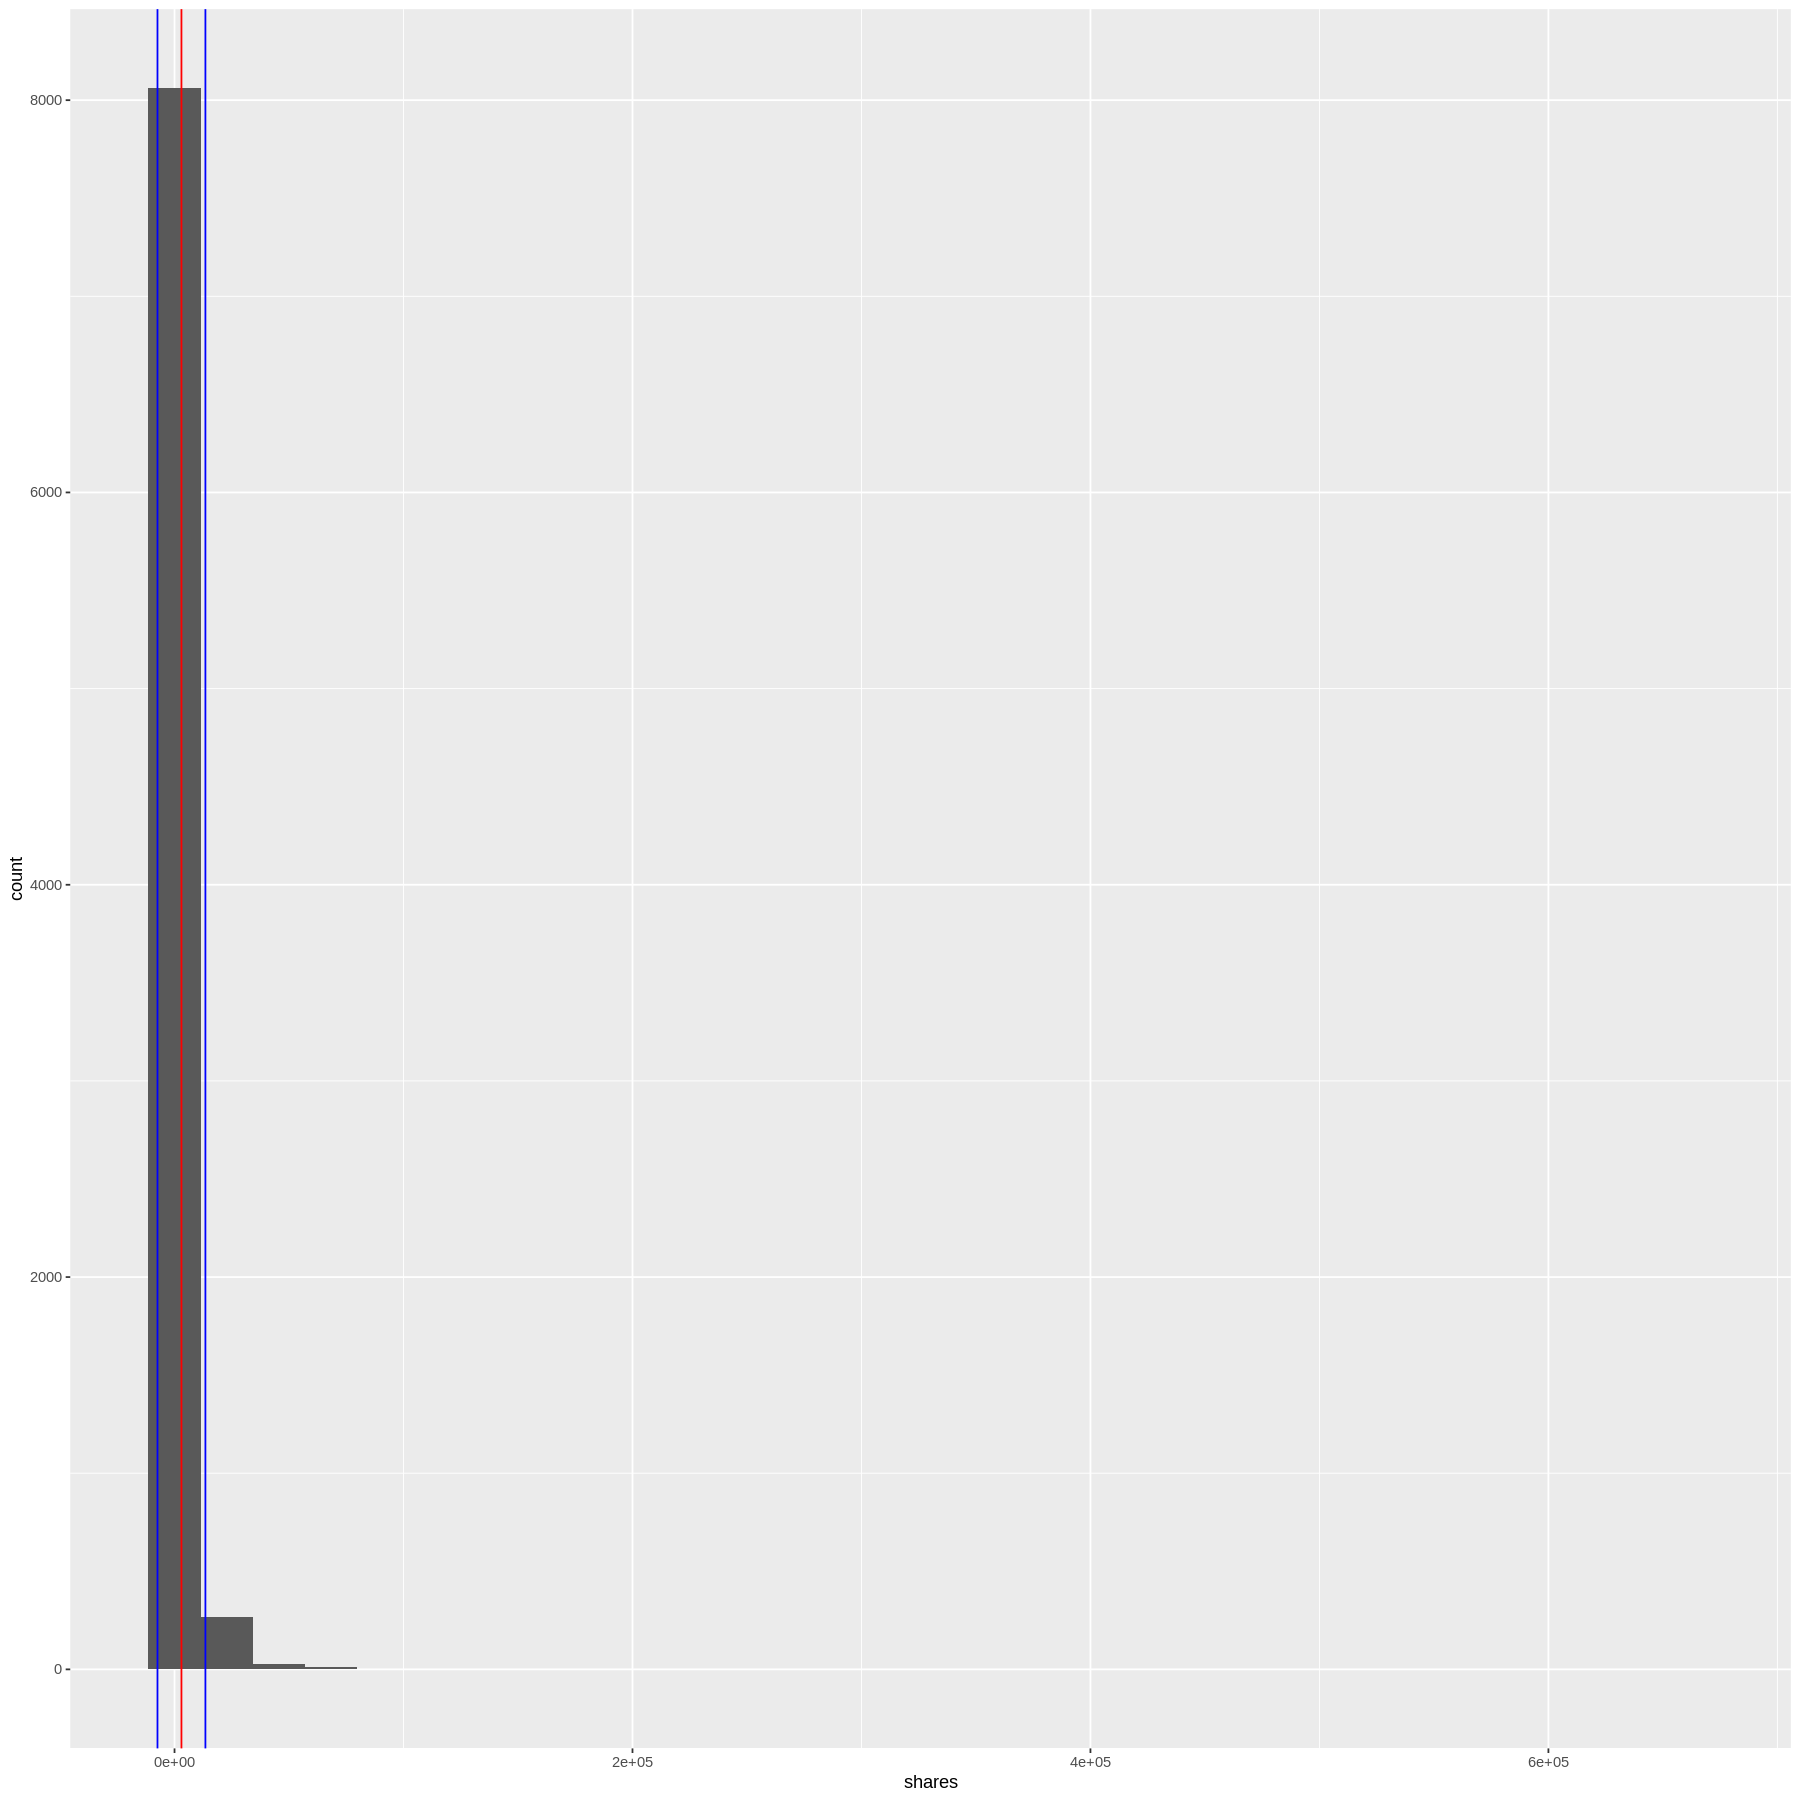

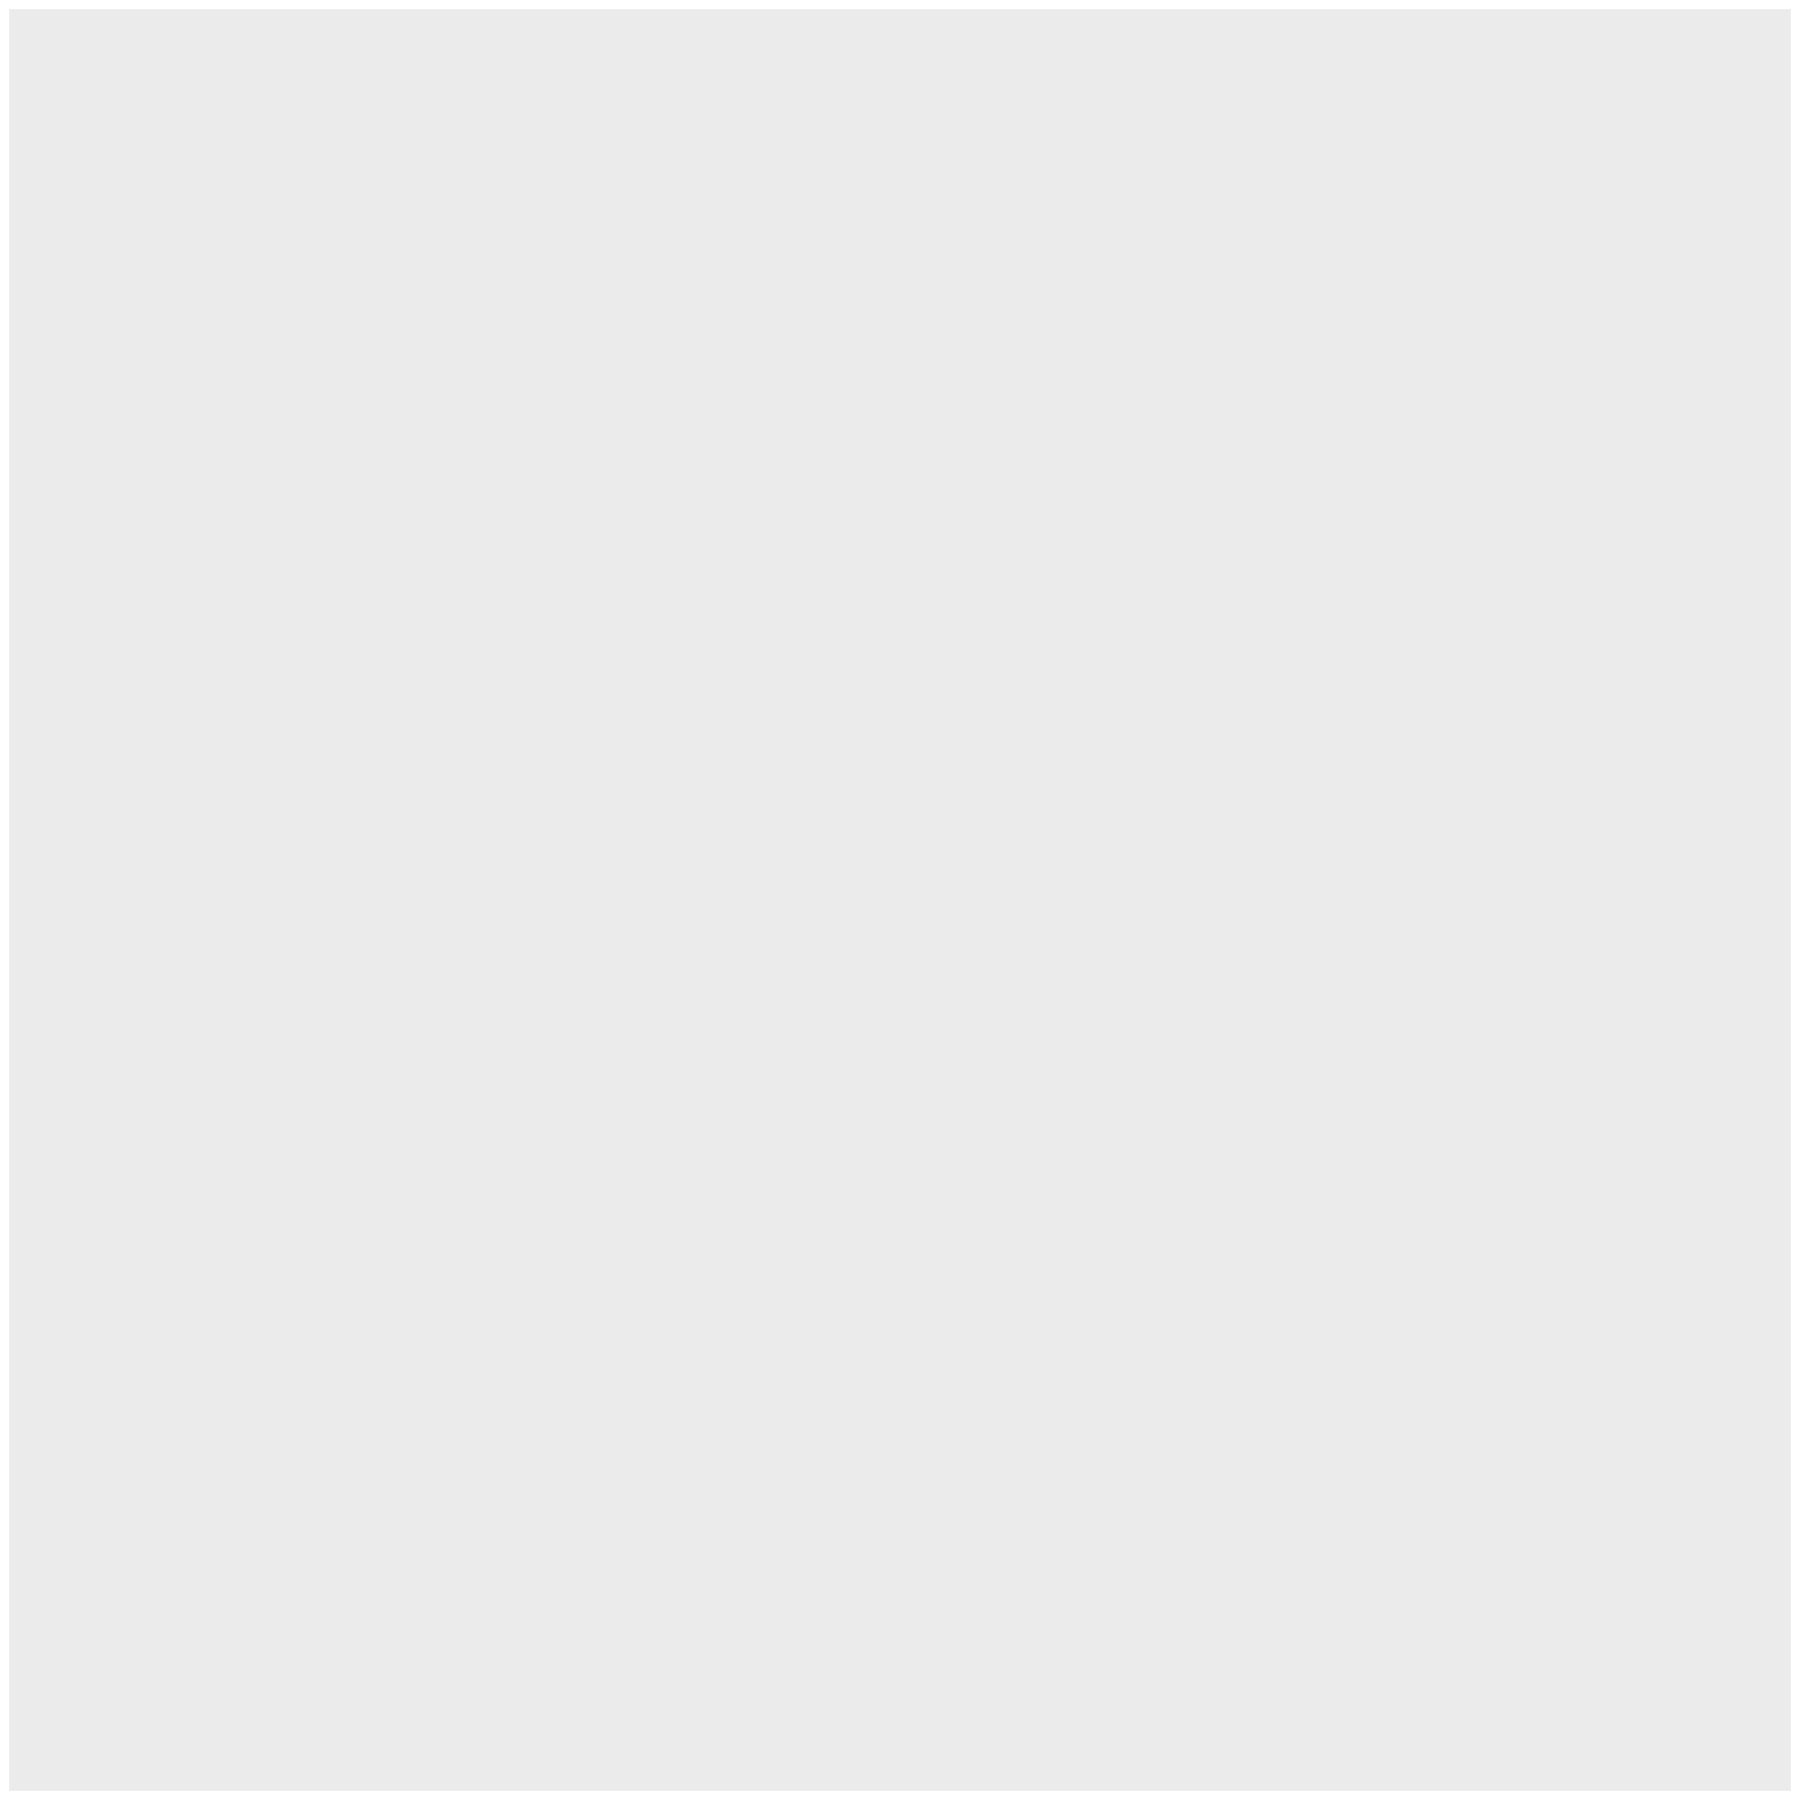

In [45]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 15, repr.plot.height = 15)


lm_rmspe <- share_summary %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()

std_dev <- pull(summarize(publishing_test, sd(shares)))
mean <- pull(summarize(publishing_test, mean(shares)))
std_dev



ggplot(publishing_test, aes(x=shares)) +
    geom_histogram()+
    geom_vline(aes(xintercept=mean+lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean-lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean),color="red")

ggplot(publishing_test)

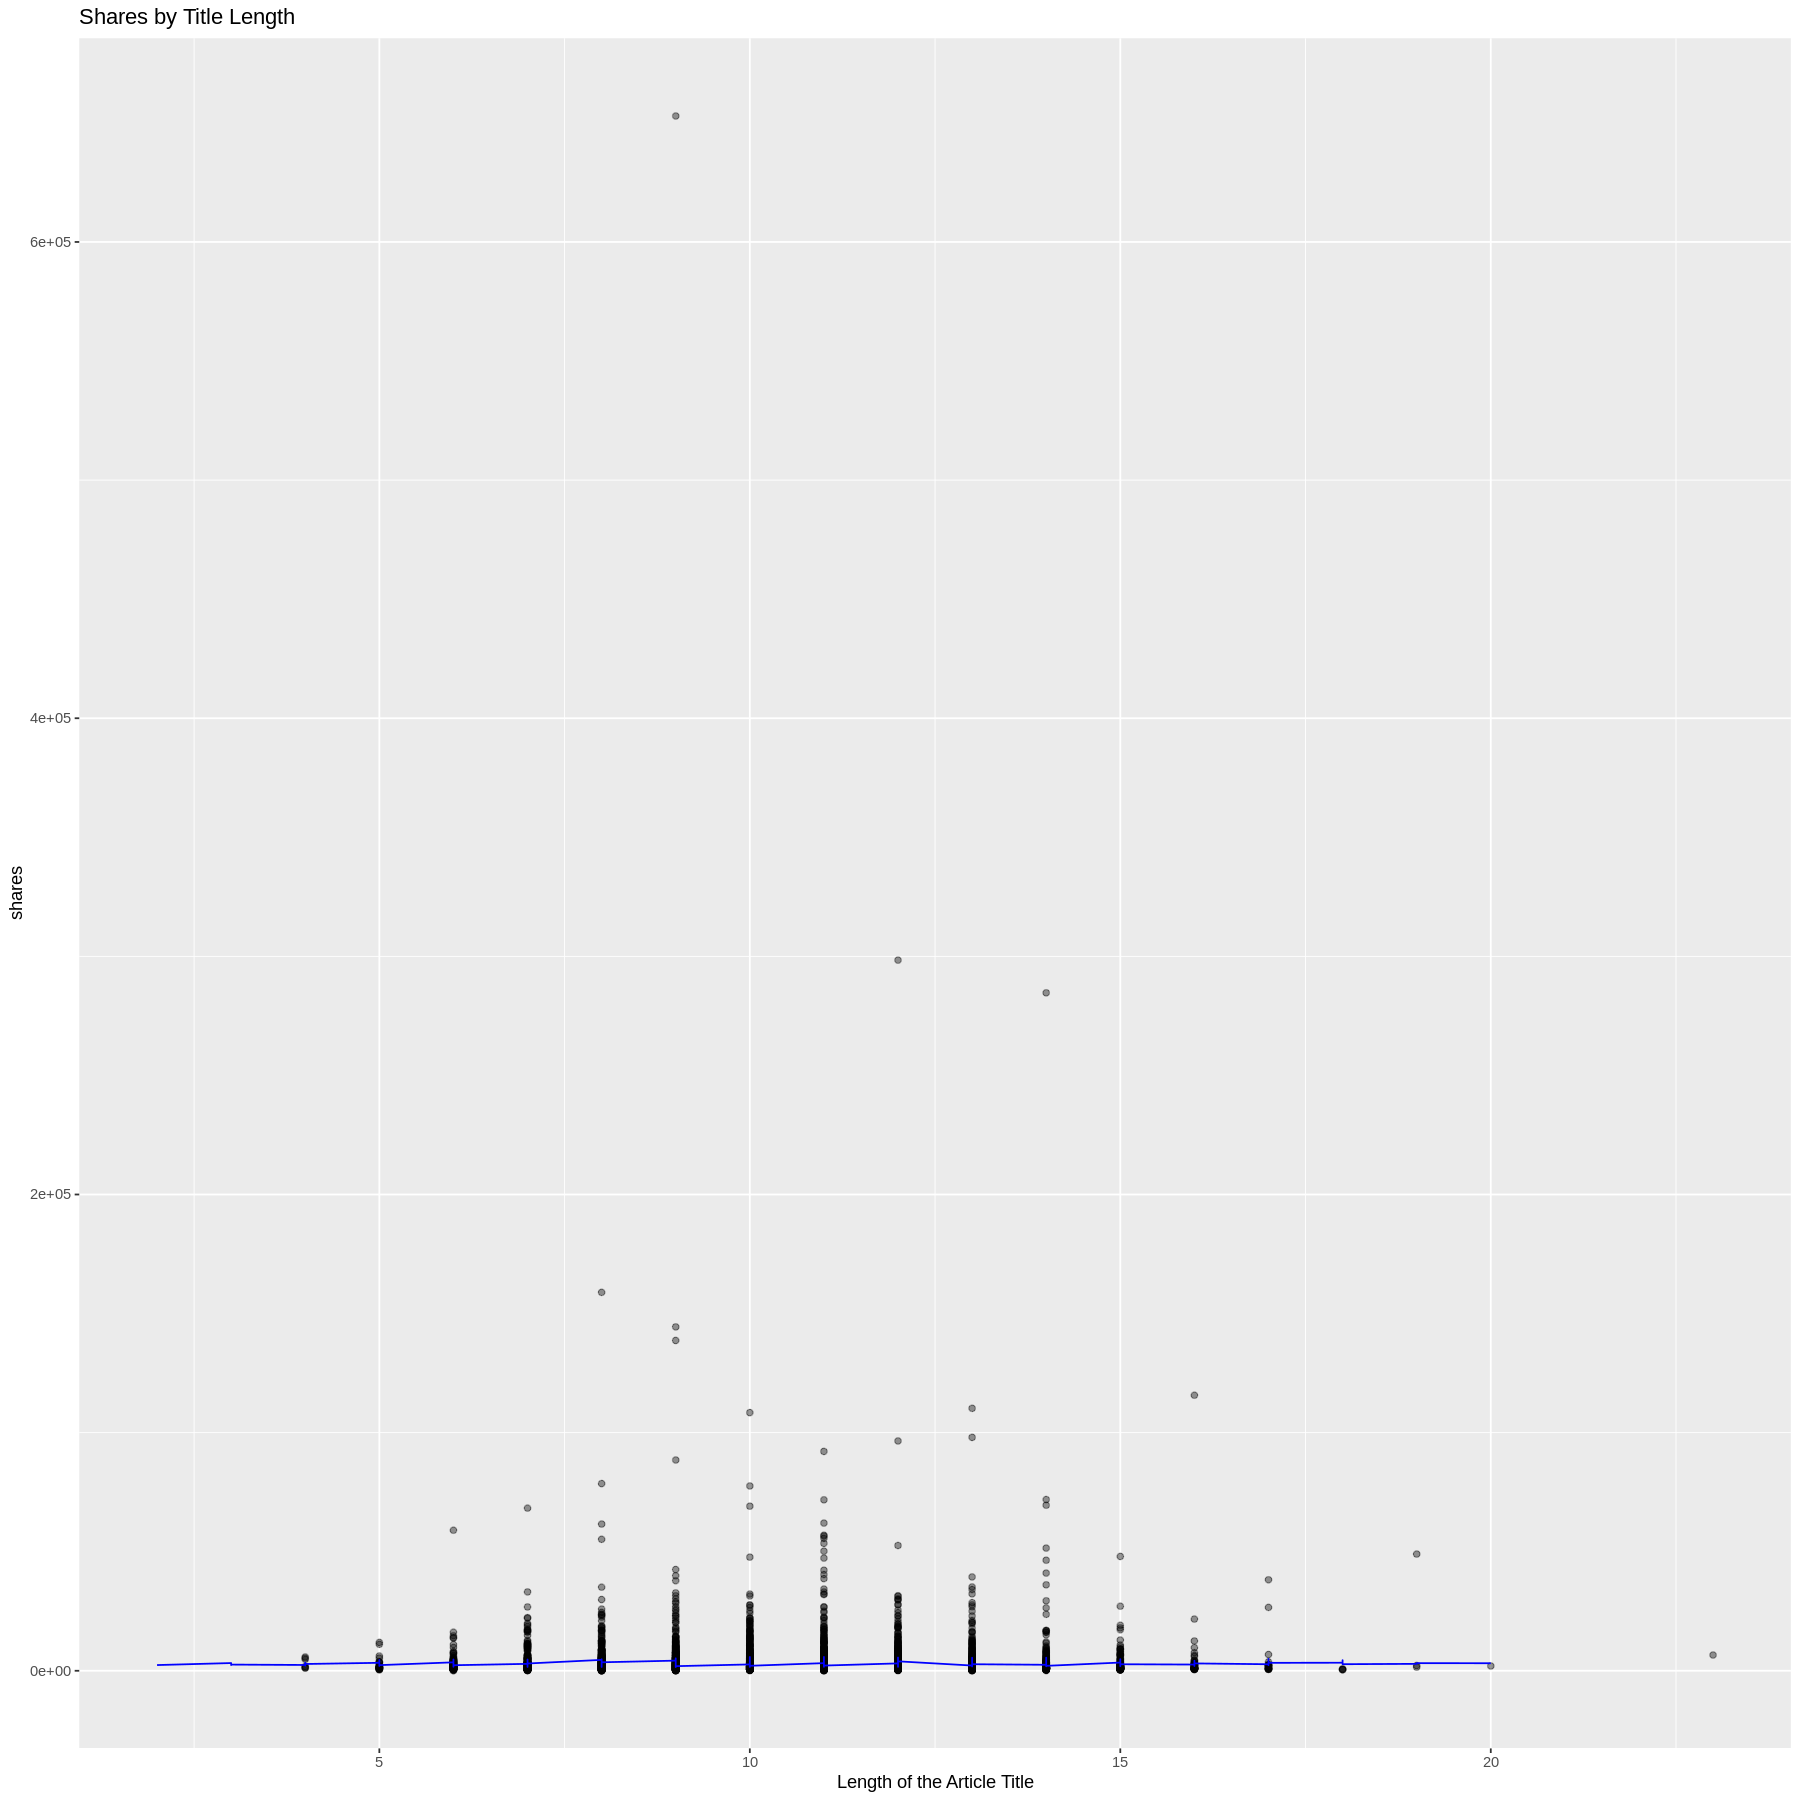

In [53]:
share_preds <- share_best_fit %>%
    predict(publishing_train) %>%
    bind_cols(publishing_train)

options(repr.plot.width = 15, repr.plot.height = 15)


title_length_plot <- ggplot(publishing_test, aes(x = n_tokens_title, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Length of the Article Title")+
  geom_line(data = share_preds, aes(x = n_tokens_title, y = .pred), color = "blue")+
  ggtitle("Shares by Title Length")
title_length_plot

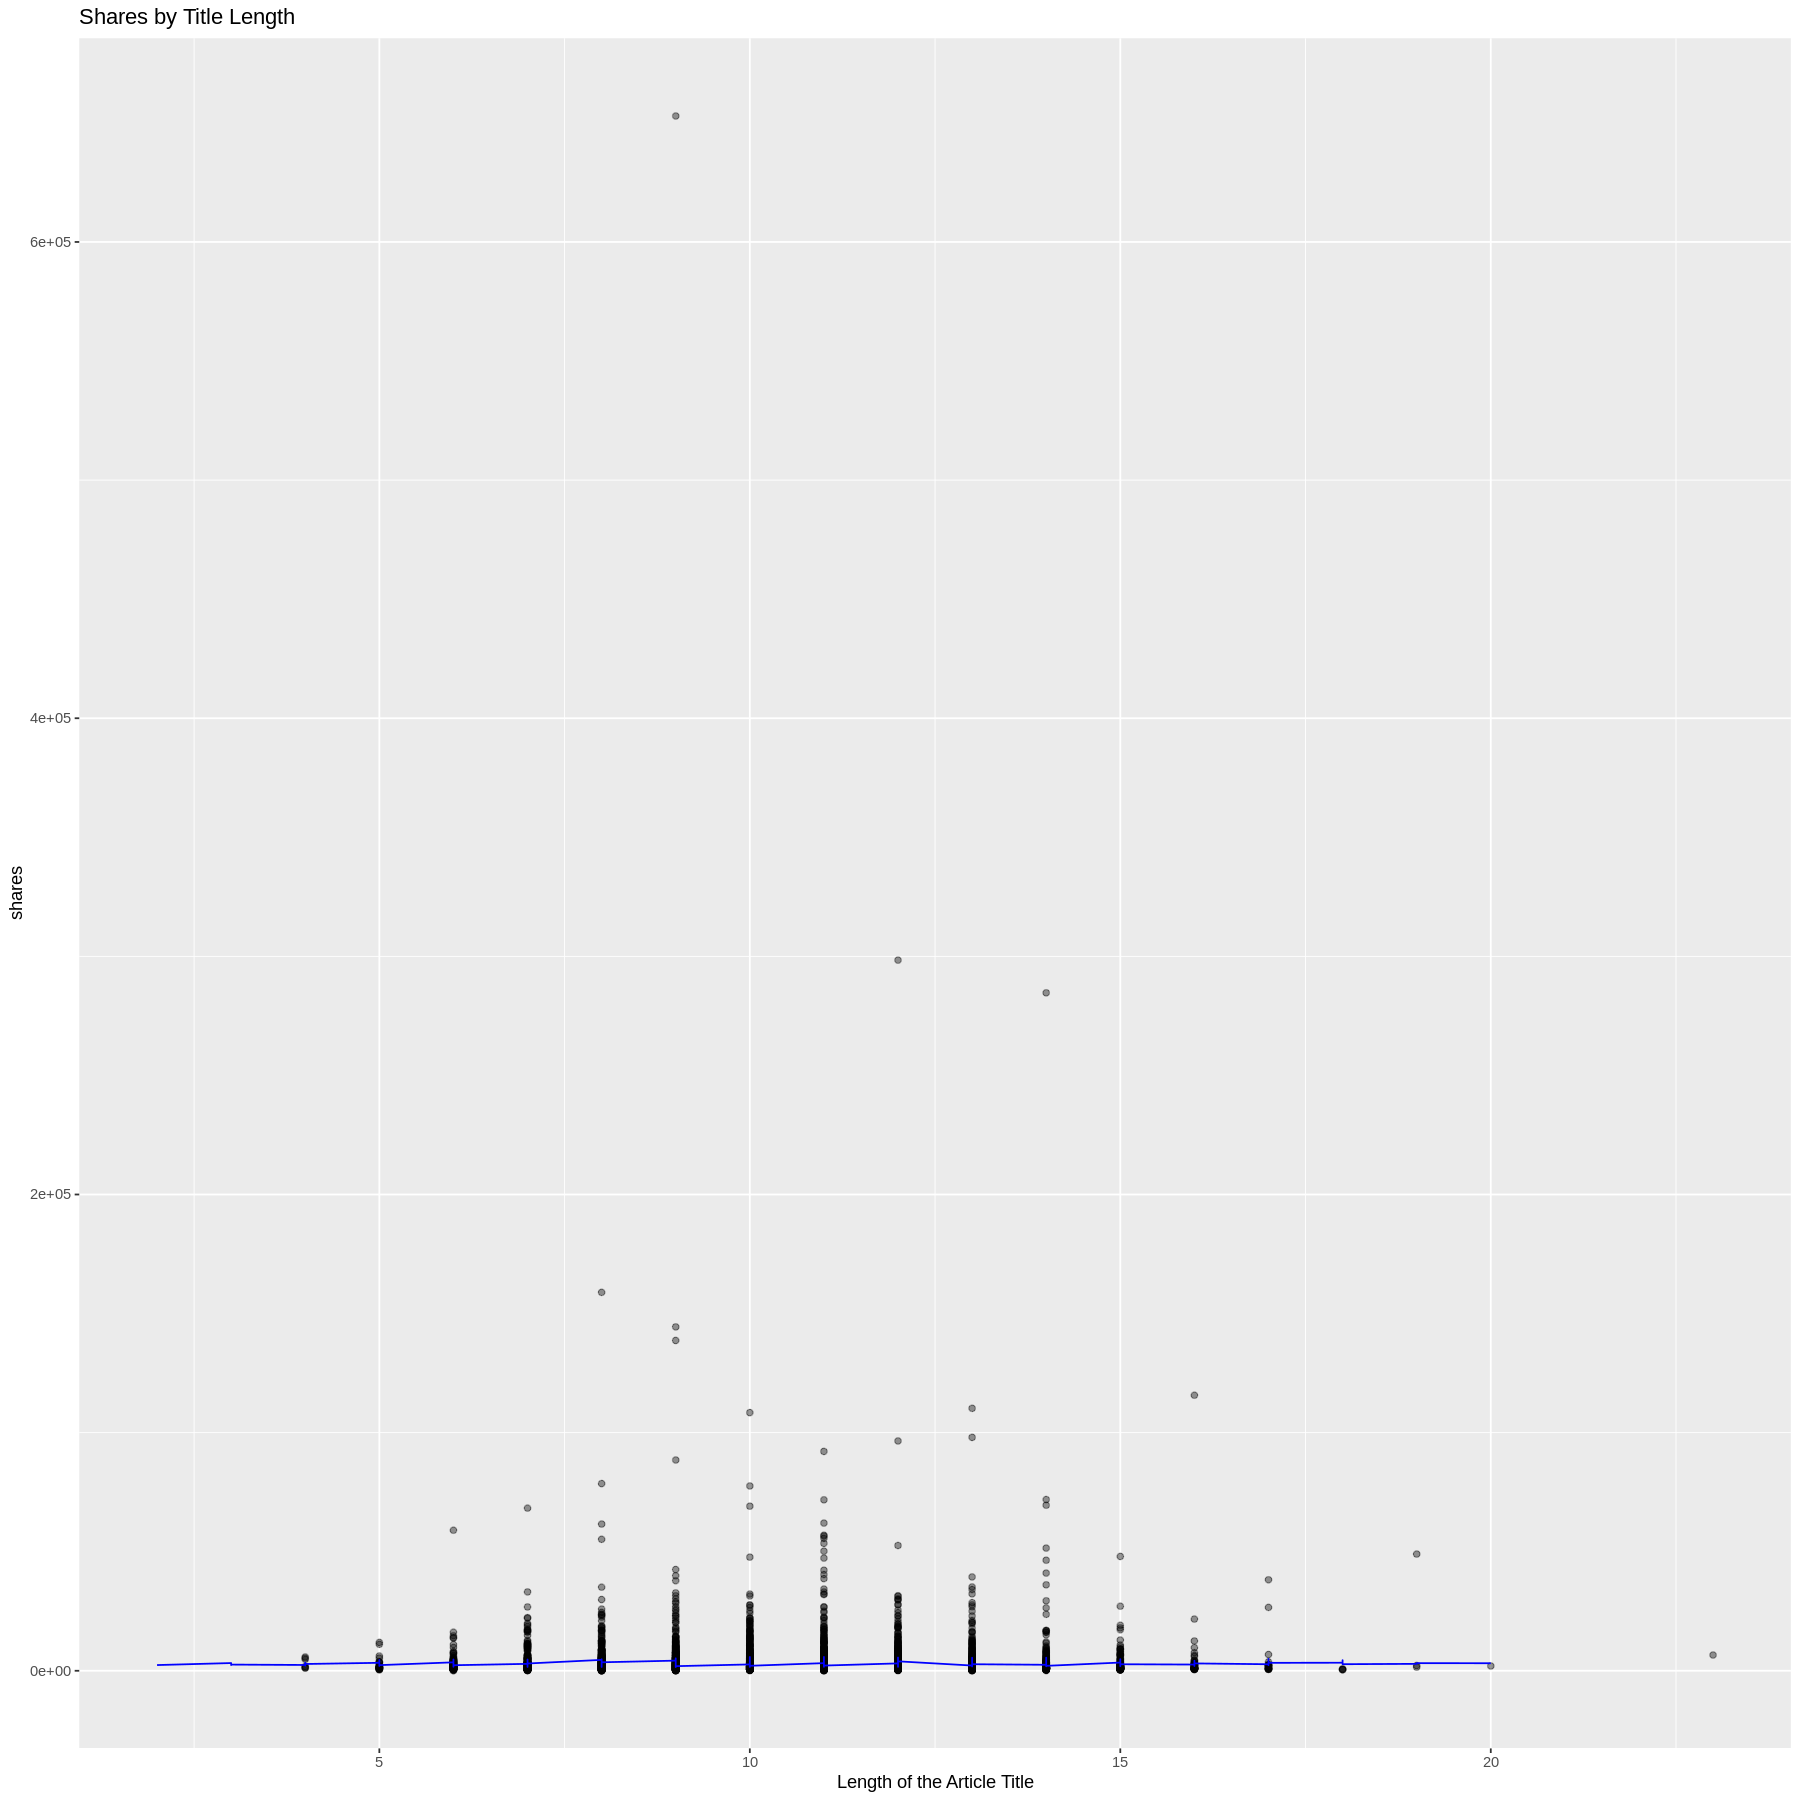

In [54]:
metadata_plot <- ggplot(publishing_test, aes(x = n_tokens_title, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Length of the Article Title")+
  geom_line(data = share_preds, aes(x = n_tokens_title, y = .pred), color = "blue")+
  ggtitle("Shares by Title Length")
metadata_plot

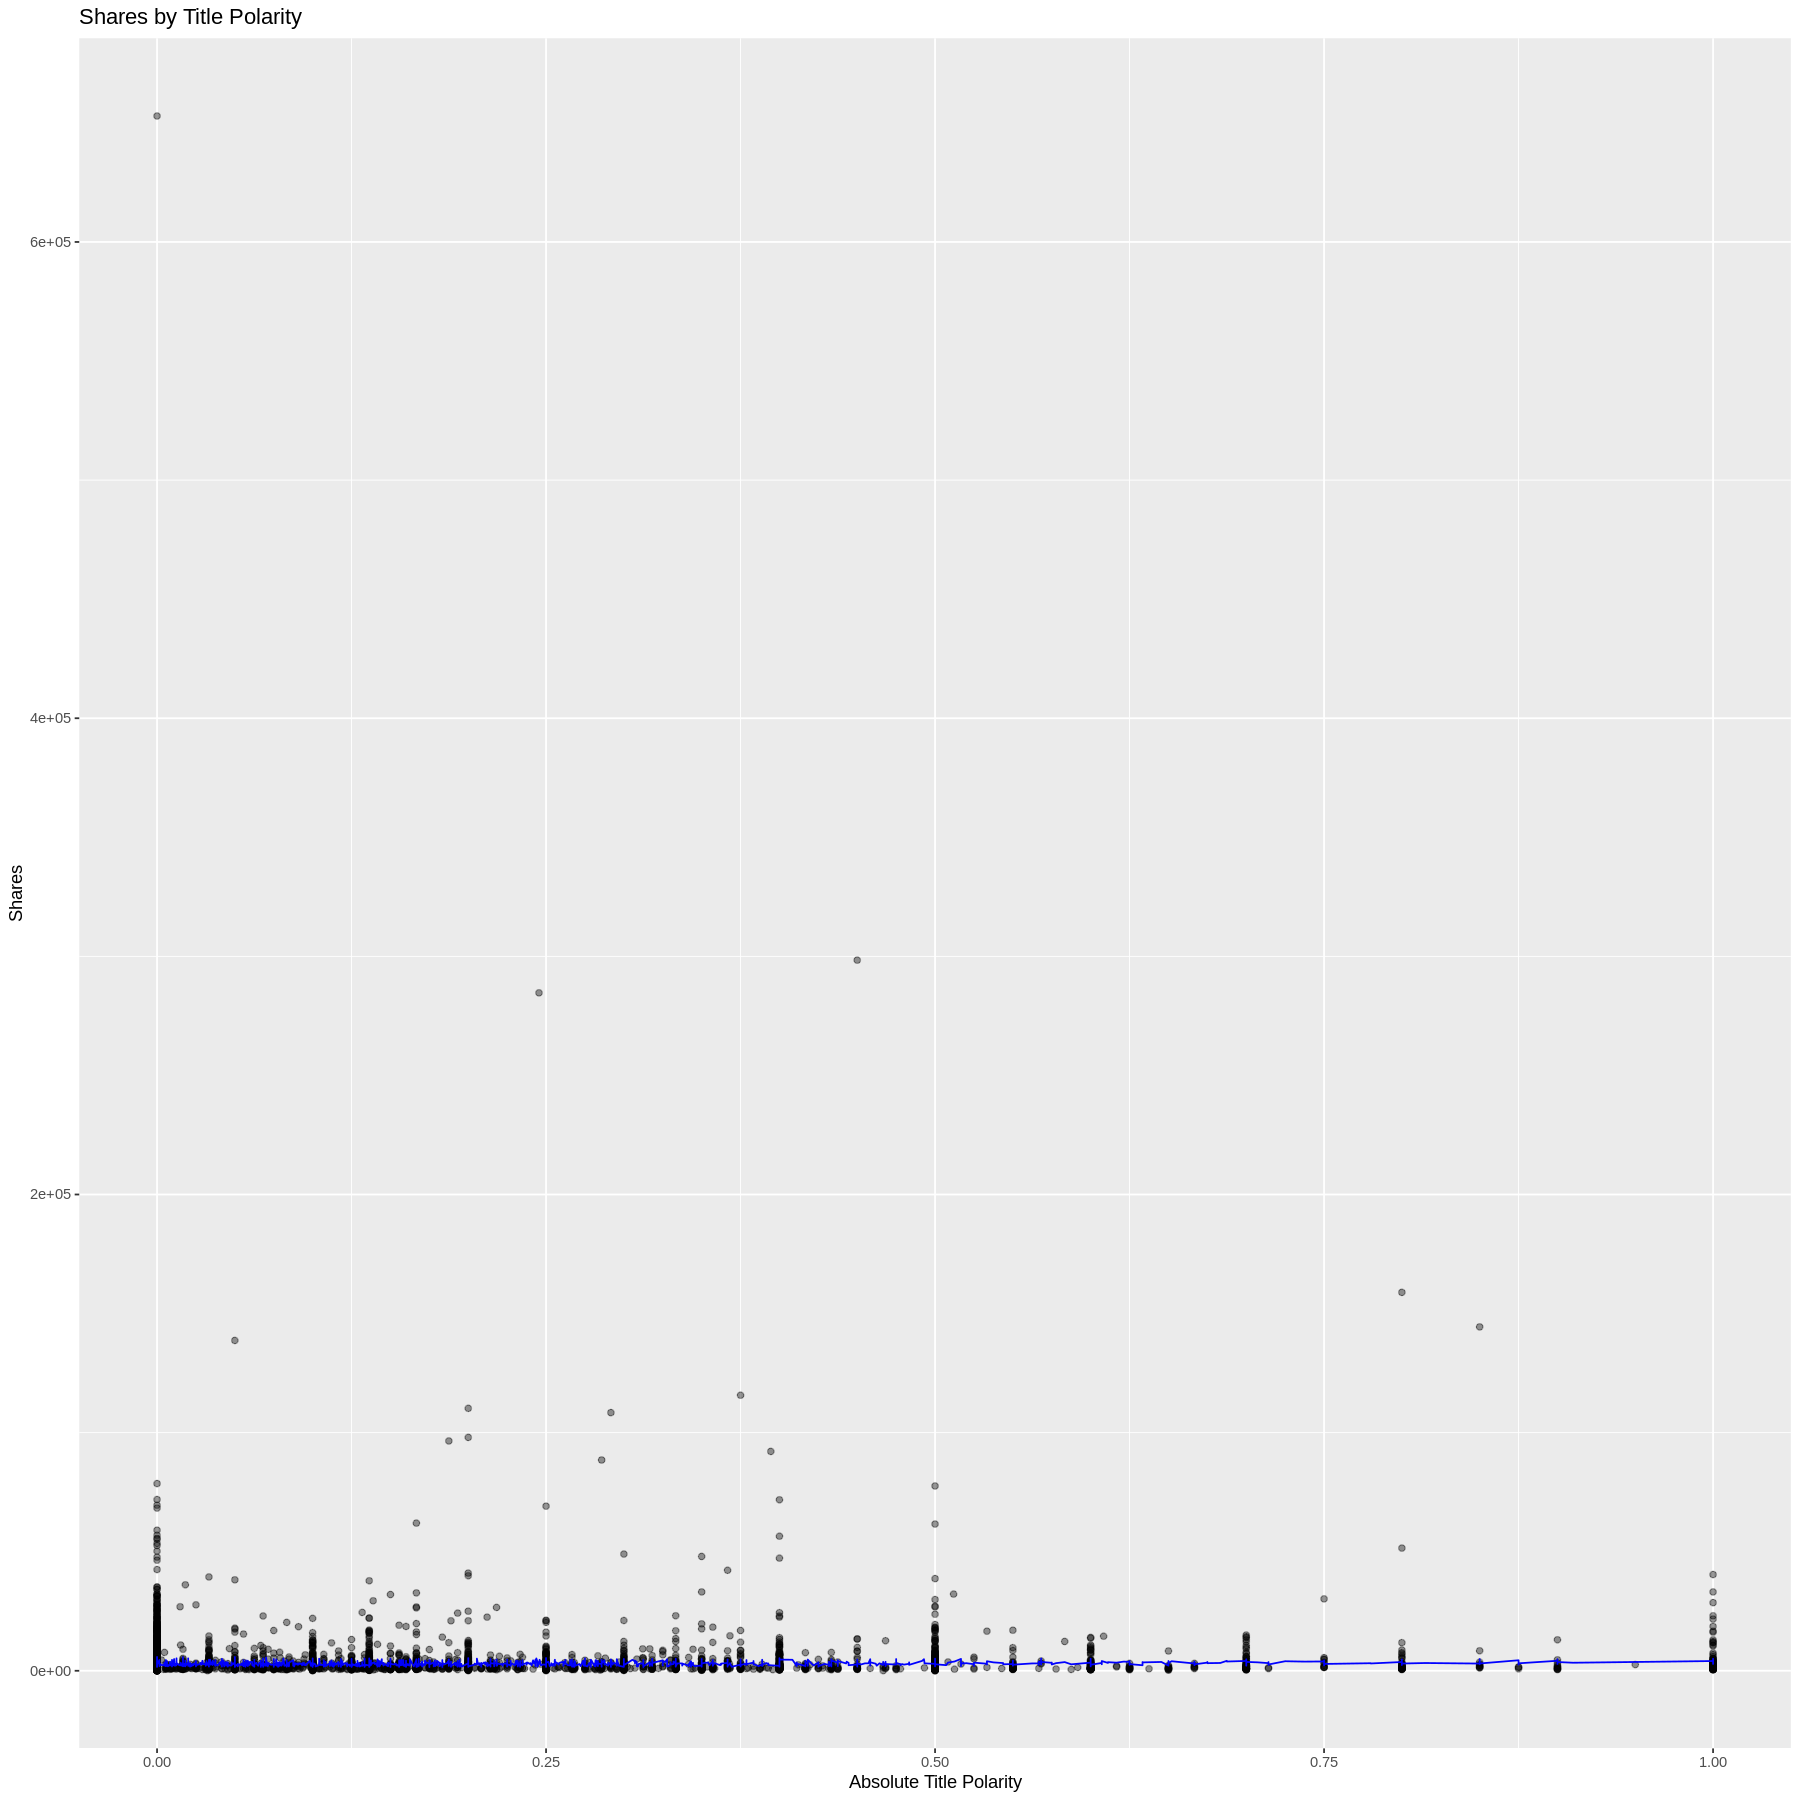

In [55]:
title_polarity_plot <- ggplot(publishing_test, aes(x = abs_title_sentiment_polarity, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Absolute Title Polarity", y="Shares")+
  geom_line(data = share_preds, aes(x = abs_title_sentiment_polarity, y = .pred), color = "blue")+
  ggtitle("Shares by Title Polarity")
title_polarity_plot

In [52]:
explore_data <- named_data %>%
    mutate (Popular = shares > 1500)%>%
    mutate(Popular = as_factor(Popular)) %>%
    select(-url, -timedelta)
head(explore_data)
explore_data %>%
    group_by(Popular) %>%
    summarize(n=n()) %>%
    select(Popular, n)

title_length,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,⋯,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,absolute_title_subjectivity,absolute_title_sentiment_polarity,shares,Popular
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,⋯,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593,FALSE
9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,⋯,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711,FALSE
9,211,0.5751295,1,0.6638655,3,1,1,0,4.393365,⋯,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500,FALSE
9,531,0.5037879,1,0.6656347,9,0,1,0,4.404896,⋯,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200,FALSE
13,1072,0.4156456,1,0.5408895,19,19,20,0,4.682836,⋯,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505,FALSE
10,370,0.5598886,1,0.6981982,2,2,0,0,4.359459,⋯,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855,FALSE


`summarise()` ungrouping output (override with `.groups` argument)



Popular,n
<fct>,<int>
FALSE,21405
TRUE,18239


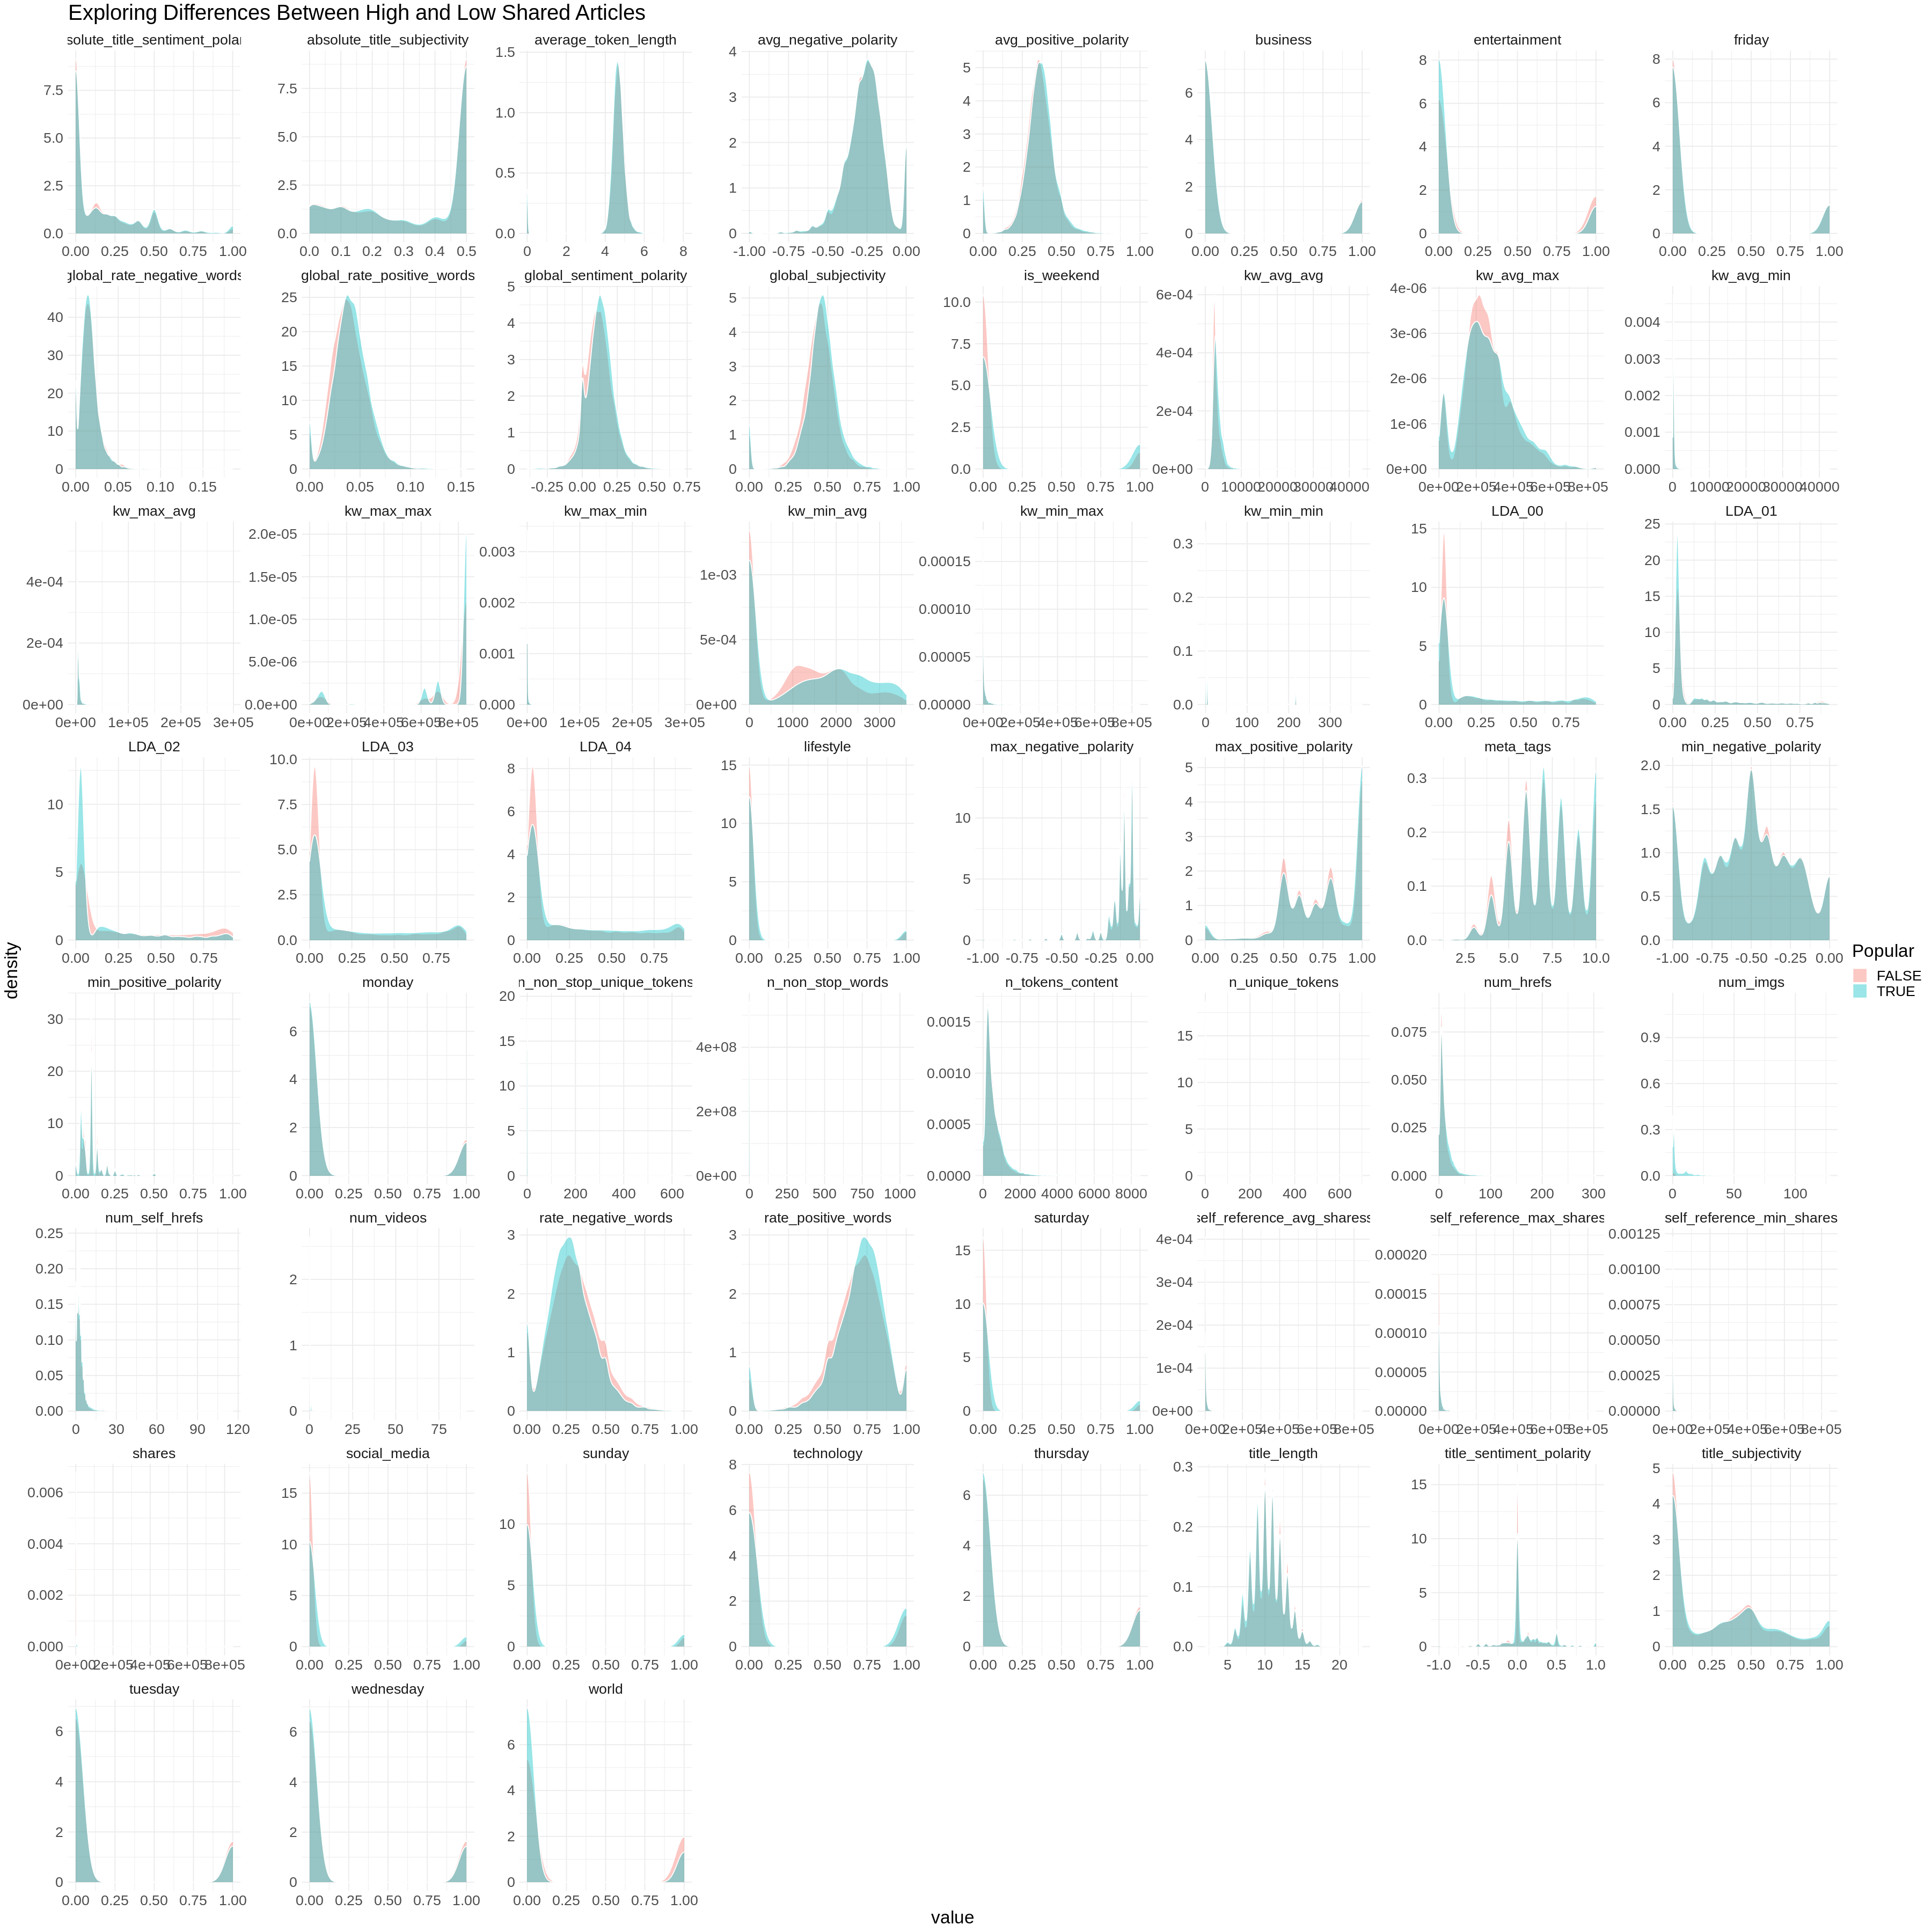

In [53]:
options(repr.plot.height = 30, repr.plot.width = 30)
explore_data %>%
    pivot_longer(cols = -Popular, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = Popular)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
        ggtitle("Exploring Differences Between High and Low Shared Articles")